In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import json
import random
import matplotlib.pyplot as plt
%matplotlib inline 

import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import rgb2hex

from sklearn.cluster import KMeans

!pip install geopy
from geopy.geocoders import Nominatim

import requests
from pandas.io.json import json_normalize

!pip install BeautifulSoup4
from bs4 import BeautifulSoup

!pip install folium
import folium

print('done')

done


In [2]:
soup = BeautifulSoup(requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text, 'html.parser')

table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [3]:
df = df.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(', '.join).reset_index()

df.head(12)

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park"
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge"
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [4]:
!wget -O Geospatial_Coordinates.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv
df_coords = pd.read_csv('Geospatial_Coordinates.csv')

df_coords.head()

--2021-09-12 16:50:26--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2788 (2.7K) [text/csv]
Saving to: ‘Geospatial_Coordinates.csv’

Geospatial_Coordina 100%[===================>]   2.72K  --.-KB/s    in 0s      

2021-09-12 16:50:26 (109 MB/s) - ‘Geospatial_Coordinates.csv’ saved [2788/2788]



,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [5]:
df_coords.rename(columns = {'Postal Code': 'PostalCode'}, inplace = True)
df_coords.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [6]:
df_merged = pd.merge(df, df_coords, on='PostalCode', how='inner')
df_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [7]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are 43.6534817, -79.3839347.


In [8]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Borough'], df_merged['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [9]:
CLIENT_ID = '01N0DJHK0M4LX0OPLYFUNYYFLMTUCRIJGSPOZYH4ZEWG1U0V' # your Foursquare ID
CLIENT_SECRET = 'AEIJLPGJ3COV0MLS4Q1TV32IRTMVJ0UUHAFV4ZEVV44ZOP3G' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
ACCESS_TOKEN = 'ZVGGT00ROHSBZTRBFBWOMS1GGOESFLDBJYL3C1FSCPK12AUO'

In [10]:
radius = 500

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [11]:
toronto_venues = getNearbyVenues(names=df_merged['Neighborhood'],
                                   latitudes=df_merged['Latitude'],
                                   longitudes=df_merged['Longitude'])
                                  

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Don Mills South
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
The Danforth  East
The Danforth West, Riverdale


In [12]:
print(toronto_venues.shape)
toronto_venues.head()

(2147, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Scarborough Historical Society,43.788755,-79.162438,History Museum
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [13]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",9,9,9,9,9,9
"Bathurst Manor, Wilson Heights, Downsview North",21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",26,26,26,26,26,26
Berczy Park,60,60,60,60,60,60
"Birch Cliff, Cliffside West",4,4,4,4,4,4
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16


In [14]:
print('There are {} unique categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 272 unique categories.


In [15]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
cols = toronto_onehot.columns.tolist()
cols.insert(0, cols.pop(cols.index('Neighborhood')))
toronto_onehot = toronto_onehot.reindex(columns= cols)

toronto_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [16]:
toronto_onehot.shape

(2147, 272)

In [17]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.000000,0.000000,0.00,0.000000,0.000000,0.

In [18]:
toronto_grouped.shape

(100, 272)

In [19]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0             Clothing Store   0.2
1  Latin American Restaurant   0.2
2             Breakfast Spot   0.2
3                     Lounge   0.2
4               Skating Rink   0.2


----Alderwood, Long Branch----
            venue  freq
0     Pizza Place  0.22
1     Coffee Shop  0.11
2    Skating Rink  0.11
3  Sandwich Place  0.11
4             Pub  0.11


----Bathurst Manor, Wilson Heights, Downsview North----
                       venue  freq
0                Coffee Shop  0.10
1                       Bank  0.10
2                   Pharmacy  0.05
3  Middle Eastern Restaurant  0.05
4              Shopping Mall  0.05


----Bayview Village----
                 venue  freq
0  Japanese Restaurant  0.25
1                 Bank  0.25
2   Chinese Restaurant  0.25
3                 Café  0.25
4          Music Venue  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0  Italian Restaurant  0.08
1         Coffee Shop  0.08

In [20]:
#Sort Venues in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Breakfast Spot,Skating Rink,Latin American Restaurant,Clothing Store,Yoga Studio,Drugstore,Dive Bar,Dog Run,Doner Restaurant
1,"Alderwood, Long Branch",Pizza Place,Pharmacy,Skating Rink,Dance Studio,Coffee Shop,Pub,Sandwich Place,Gym,Airport Terminal,Farmers Market
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Frozen Yogurt Shop,Bridal Shop,Sandwich Place,Diner,Restaurant,Middle Eastern Restaurant,Supermarket,Intersection
3,Bayview Village,Café,Japanese Restaurant,Bank,Chinese Restaurant,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Yoga Studio
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Sandwich Place,Italian Restaurant,Grocery Store,Cupcake Shop,Indian Restaurant,Pub,Sushi Restaurant,Restaurant,Café
5,Berczy Park,Coffee Shop,Bakery,Beer Bar,Farmers Market,Cocktail Bar,Restaurant,Pharmacy,Seafood Restaurant,Cheese Shop,Breakfast Spot
6,"Birch Cliff, Cliffside West",College Stadium,Skating Rink,General Entertainment,Café,Electronics Store,Eastern European Restaurant,Ethiopian Restaurant,Dumpling Restaurant,Drugstore,Dim Sum Restaurant
7,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Nightclub,Coffee Shop,Grocery Store,Burrito Place,Italian Restaurant,Bar,Bakery,Intersection
8,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Terminal,Airport Service,Harbor / Marina,Rental Car Location,Coffee Shop,Plane,Sculpture Garden,Boutique,Boat or Ferry,Airport Lounge
9,Caledonia-Fairbanks,Park,Women's Store,Pool,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run


### Determining the best value for K number of clusters

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


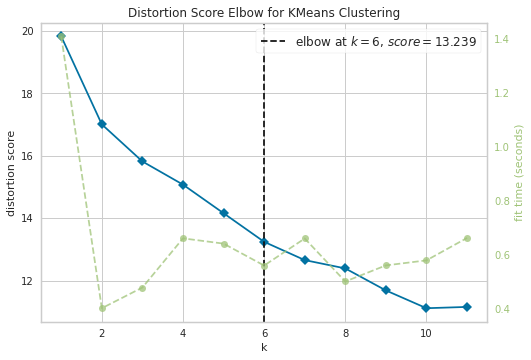

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
#Elbow method to determine value of K Clusters
!pip install yellowbrick

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)


# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))

visualizer.fit(toronto_grouped_clustering)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### Clustering Neighbourhoods

In [22]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2], dtype=int32)

In [23]:
toronto_grouped_clustering.head()

,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.

In [24]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge toronto_grouped with df_merged to add latitude/longitude for each neighborhood

toronto_merged = df_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood',how ='inner')

toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,4,Fast Food Restaurant,Donut Shop,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Yoga Studio,Dim Sum Restaurant
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,1,History Museum,Bar,Yoga Studio,Drugstore,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1,Mexican Restaurant,Donut Shop,Restaurant,Rental Car Location,Bank,Intersection,Medical Center,Breakfast Spot,Electronics Store,Dumpling Restaurant
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1,Coffee Shop,Other Repair Shop,Convenience Store,Korean BBQ Restaurant,Yoga Studio,Donut Shop,Distribution Center,Dive Bar,Dog Run,Doner Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1,Hakka Restaurant,Bakery,Thai Restaurant,Caribbean Restaurant,Athletics & Sports,Gas Station,Bank,Fried Chicken Joint,Dog Run,Dive Bar


### Generating Cluster Map

In [25]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examining Clusters

In [26]:
# Cluster 1
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
91,Etobicoke,0,Pool,Baseball Field,Yoga Studio,Donut Shop,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Drugstore
97,North York,0,Baseball Field,Yoga Studio,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Fast Food Restaurant


In [27]:
# Cluster 2
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Scarborough,1,History Museum,Bar,Yoga Studio,Drugstore,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
2,Scarborough,1,Mexican Restaurant,Donut Shop,Restaurant,Rental Car Location,Bank,Intersection,Medical Center,Breakfast Spot,Electronics Store,Dumpling Restaurant
3,Scarborough,1,Coffee Shop,Other Repair Shop,Convenience Store,Korean BBQ Restaurant,Yoga Studio,Donut Shop,Distribution Center,Dive Bar,Dog Run,Doner Restaurant
4,Scarborough,1,Hakka Restaurant,Bakery,Thai Restaurant,Caribbean Restaurant,Athletics & Sports,Gas Station,Bank,Fried Chicken Joint,Dog Run,Dive Bar
5,Scarborough,1,Women's Store,Playground,Drugstore,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
6,Scarborough,1,Train Station,Department Store,Coffee Shop,Hobby Shop,Chinese Restaurant,Yoga Studio,Discount Store,Distribution Center,Dive Bar,Dog Run
7,Scarborough,1,Bakery,Metro Station,Intersection,Ice Cream Shop,Bus Line,Soccer Field,Park,Eastern European Restaurant,Dumpling Restaurant,Drugstore
8,Scarborough,1,American Restaurant,Motel,Yoga Studio,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore
9,Scarborough,1,College Stadium,Skating Rink,General Entertainment,Café,Electronics Store,Eastern European Restaurant,Ethiopian Restaurant,Dumpling Restaurant,Drugstore,Dim Sum Restaurant
10,Scarborough,1,Indian Restaurant,Pet Store,Vietnamese Restaurant,Chinese Restaurant,Doner Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run


In [28]:
# Cluster 3
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,North York,2,Park,Yoga Studio,Drugstore,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
23,North York,2,Park,Convenience Store,Yoga Studio,Drugstore,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
30,North York,2,Airport,Park,Yoga Studio,Drugstore,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
40,East York/East Toronto,2,Park,Convenience Store,Yoga Studio,Drugstore,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
74,York,2,Park,Women's Store,Pool,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run
98,York,2,Park,Yoga Studio,Drugstore,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant


In [29]:
# Cluster 4
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Scarborough,3,Playground,Park,Intersection,Yoga Studio,Doner Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run
25,North York,3,Fast Food Restaurant,Park,Food & Drink Shop,Ethiopian Restaurant,Electronics Store,Event Space,Eastern European Restaurant,Dumpling Restaurant,Dim Sum Restaurant,Drugstore
44,Central Toronto,3,Business Service,Park,Bus Line,Swim School,Yoga Studio,Doner Restaurant,Distribution Center,Dive Bar,Dog Run,Donut Shop
50,Downtown Toronto,3,Park,Playground,Trail,Yoga Studio,Doner Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run
64,Central Toronto,3,Park,Sushi Restaurant,Trail,Jewelry Store,Yoga Studio,Doner Restaurant,Discount Store,Distribution Center,Dive Bar,Dog Run
72,North York,3,Pizza Place,Park,Bakery,Japanese Restaurant,Doner Restaurant,Discount Store,Distribution Center,Dive Bar,Dog Run,Donut Shop
73,York,3,Field,Park,Hockey Arena,Trail,Doner Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run
79,North York,3,Park,Bakery,Construction & Landscaping,Trail,Yoga Studio,Doner Restaurant,Discount Store,Distribution Center,Dive Bar,Dog Run
90,Etobicoke,3,River,Park,Pool,Yoga Studio,Doner Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run
100,Etobicoke,3,Pizza Place,Sandwich Place,Park,Mobile Phone Shop,Dog Run,Diner,Discount Store,Distribution Center,Dive Bar,Doner Restaurant


In [30]:
# Cluster 5
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,4,Fast Food Restaurant,Donut Shop,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Yoga Studio,Dim Sum Restaurant


In [31]:
# Cluster 6
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
96,North York,5,Pizza Place,Donut Shop,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Drugstore,Harbor / Marina


In [32]:
# Cluster 7
toronto_merged.loc[toronto_merged['Cluster Labels'] == 6, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
48,Central Toronto,6,Trail,Yoga Studio,Department Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant


Cluster 2 contains a significant number of neighbourhoods in which Cafe or Coffee Shop appears in the top 3 most common venue types, so this is likely the area we will focus on.

In [32]:
#getting cafe and coffee shop locations from foursquare

cafe_Category_id = '4bf58dd8d48988d16d941735'

cafe_cluster_id = 1
df_toronto_cafes = df_merged[df_merged['Neighborhood'].isin(toronto_merged.loc[toronto_merged['Cluster Labels'] == cafe_cluster_id, 'Neighborhood'])]


def getCafes(row):
            
        # create the API request URL
        cafe_url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        row['Latitude'], 
        row['Longitude'],
        cafe_Category_id,
        radius, 
        LIMIT)
        
        
        count = len(requests.get(cafe_url).json()["response"]['venues'])

    # return count
        return pd.Series(count)

    
print('done')
    


done


In [33]:
# Apply the above function on each neighbourhood in our selected cluster
number_of_cafes = df_toronto_cafes.apply(getCafes, axis=1)

df_toronto_cafes['Number of Cafes'] = number_of_cafes

df_toronto_cafes

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,PostalCode,Borough,Neighborhood,Latitude,Longitude,Number of Cafes
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,0
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,2
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,0
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029,0
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577,1
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476,0
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,1
10,M1P,Scarborough,"Dorset Park, Wexford Heights, Scarborough Town...",43.757410,-79.273304,0


In [39]:
df_cafes_sorted = df_toronto_cafes.sort_values(by = ['Number of Cafes'], ascending = False)

In [40]:
print('The mean number of cafes per neighbourhood is', df_cafes_sorted['Number of Cafes'].mean())

The mean number of cafes per neighbourhood is 10.3


In [41]:
print('The median number of cafes per neighbourhood is', df_cafes_sorted['Number of Cafes'].median())

The median number of cafes per neighbourhood is 2.5


<AxesSubplot:xlabel='Neighborhood'>

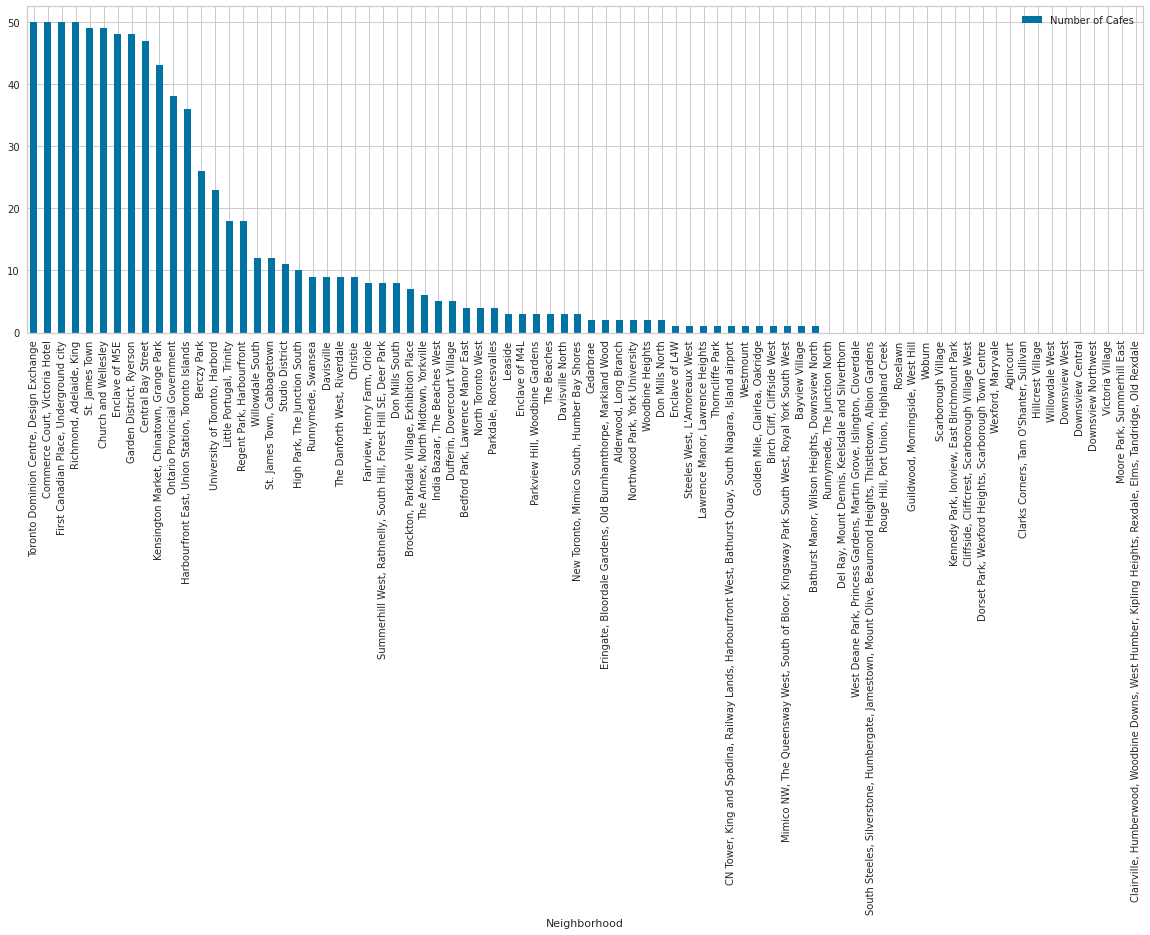

In [45]:
import matplotlib as plt
df_cafes_sorted.plot(kind = 'bar', x= "Neighborhood", y= "Number of Cafes", figsize = (20, 6))